In [1]:
# %%
print('Cell 1: Starting imports and device configuration')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.models import VGG19_Weights
import cv2
import numpy as np
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.cuda import amp
from tqdm import tqdm
import torchvision.transforms.functional as TF
import random

print('Cell 1: Imports completed successfully')
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'CUDA device name: {torch.cuda.get_device_name(0)}')
    print(f'CUDA version: {torch.version.cuda}')
print('Cell 1: Device configuration completed')


Cell 1: Starting imports and device configuration
Cell 1: Imports completed successfully
Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3060
CUDA version: 12.4
Cell 1: Device configuration completed


In [2]:
# fix DataLoader worker start-method issues on Linux
import torch.multiprocessing as mp
try:
    mp.set_start_method('fork', force=True)
    print("set multiprocessing start method to 'fork'")
except RuntimeError:
    # already set — safe to continue
    pass


set multiprocessing start method to 'fork'


In [3]:
# %%
print('Cell 2: Starting configuration setup')

# Configuration
config = {
    'batch_size': 4,        # reduced to match DataLoader in training (and to lower memory)
    'lr': 1e-4,
    'num_epochs': 100,
    'device': device,
    'save_path': 'fusion_model_improved.pth',
    'w_ssim': 1.0,
    'w_grad': 2.0,
    'w_perc': 0.05,
    'w_int': 5.0,
    'image_size': (256, 256),
    'num_workers': 2        # use 0 while debugging / avoid multiprocessing issues
}


# Imagenet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
# For single-channel IR normalize by mean/std average across channels
ir_mean = sum(imagenet_mean) / 3.0




ir_std  = sum(imagenet_std) / 3.0

print('Configuration set:')
for key, value in config.items():
    print(f'  {key}: {value}')
print('Cell 2: Configuration setup completed')


Cell 2: Starting configuration setup
Configuration set:
  batch_size: 4
  lr: 0.0001
  num_epochs: 100
  device: cuda
  save_path: fusion_model_improved.pth
  w_ssim: 1.0
  w_grad: 2.0
  w_perc: 0.05
  w_int: 5.0
  image_size: (256, 256)
  num_workers: 2
Cell 2: Configuration setup completed


In [4]:
# %%
print('Cell 3: Starting LLVIPDataset class definition with Augmentation')

class LLVIPDataset(Dataset):
    """Dataset for LLVIP visible (RGB) and infrared (grayscale) images."""
    def __init__(self, root_dir, train=True):
        self.train = train
        mode = 'train' if train else 'test'
        self.vis_path = os.path.join(root_dir, 'visible', mode)
        self.ir_path = os.path.join(root_dir, 'infrared', mode)
        
        self.vis_images = sorted([f for f in os.listdir(self.vis_path) 
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))])
        self.ir_images = sorted([f for f in os.listdir(self.ir_path) 
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))])
        
        self.pairs = [f for f in self.vis_images if f in self.ir_images]
        print(f"Found {len(self.pairs)} image pairs in {mode} set")

        # transforms (raw 0-1)
        self.transform_vis = transforms.Compose([
            transforms.Resize(config['image_size']),
            transforms.ToTensor(),   # (3,H,W) in [0,1]
        ])
        self.transform_ir = transforms.Compose([
            transforms.Resize(config['image_size']),
            transforms.ToTensor(),   # (1,H,W) in [0,1]
        ])

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_name = self.pairs[idx]
        
        vis_img = Image.open(os.path.join(self.vis_path, img_name)).convert('RGB')
        ir_img  = Image.open(os.path.join(self.ir_path, img_name)).convert('L')
        
        vis_tensor = self.transform_vis(vis_img)
        ir_tensor  = self.transform_ir(ir_img)

        # Paired augmentations
        if self.train:
            # Random horizontal flip
            if random.random() > 0.5:
                vis_tensor = TF.hflip(vis_tensor)
                ir_tensor  = TF.hflip(ir_tensor)
            # Random rotation (same angle)
            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                vis_tensor = TF.rotate(vis_tensor, angle)
                ir_tensor  = TF.rotate(ir_tensor, angle)
            # Random crop or small scale jitter could be added here (ensure paired)
        
        return vis_tensor, ir_tensor, img_name

print('Cell 3: LLVIPDataset class definition completed')


Cell 3: Starting LLVIPDataset class definition with Augmentation
Cell 3: LLVIPDataset class definition completed


In [5]:
# %%
print('Cell 4: Starting simplified collate function setup')

def collate_fn(batch):
    vis_tensors, ir_tensors, names = zip(*batch)
    vis_batch = torch.stack(vis_tensors)  # (B,3,H,W)
    ir_batch  = torch.stack(ir_tensors)   # (B,1,H,W)
    return vis_batch, ir_batch, names

print('Cell 4: Collate function simplified for batching tensors')
print('Cell 4: Simplified collate function setup completed')


Cell 4: Starting simplified collate function setup
Cell 4: Collate function simplified for batching tensors
Cell 4: Simplified collate function setup completed


In [6]:
# %%
print('Cell 6: Starting loss components definition')

class SSIM(nn.Module):
    def __init__(self, window_size=11, C1=0.01**2, C2=0.03**2):
        super().__init__()
        self.window_size = window_size
        self.C1 = C1
        self.C2 = C2
        gauss = cv2.getGaussianKernel(window_size, window_size/6)
        gauss = gauss @ gauss.T
        w = torch.from_numpy(gauss.astype(np.float32))[None, None]
        self.register_buffer('window', w)

    def _filt(self, x):
        pad = self.window_size // 2
        # Cast window to match input tensor's dtype/device
        window = self.window.to(device=x.device, dtype=x.dtype)  # (1,1,k,k)
        # Repeat window to have shape (C,1,k,k) so grouped conv works
        c = x.size(1)
        if window.shape[0] != c:
            window = window.repeat(c, 1, 1, 1)
        return F.conv2d(x, window, padding=pad, groups=c)


    def forward(self, x, y):
        mu_x = self._filt(x)
        mu_y = self._filt(y)
        mu_x2, mu_y2, mu_xy = mu_x*mu_x, mu_y*mu_y, mu_x*mu_y
        sigma_x2 = self._filt(x*x) - mu_x2
        sigma_y2 = self._filt(y*y) - mu_y2
        sigma_xy = self._filt(x*y) - mu_xy
        ssim = ((2*mu_xy + self.C1)*(2*sigma_xy + self.C2)) / ((mu_x2 + mu_y2 + self.C1)*(sigma_x2 + sigma_y2 + self.C2) + 1e-8)
        return ssim.mean()

class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=np.float32)
        ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=np.float32)
        self.register_buffer('kx', torch.from_numpy(kx)[None, None])
        self.register_buffer('ky', torch.from_numpy(ky)[None, None])

    def forward(self, fused, vis, ir):
        def grad(img):
            if img.size(1) > 1:
                img_gray = img.mean(dim=1, keepdim=True)
            else:
                img_gray = img
            kx_ = self.kx.to(device=img_gray.device, dtype=img_gray.dtype)
            ky_ = self.ky.to(device=img_gray.device, dtype=img_gray.dtype)
            gx = F.conv2d(img_gray, kx_, padding=1)
            gy = F.conv2d(img_gray, ky_, padding=1)
            return torch.sqrt(gx*gx + gy*gy + 1e-8)
        gF = grad(fused)
        gV = grad(vis)
        gI = grad(ir)
        gT = torch.max(gV, gI)
        return F.l1_loss(gF, gT)

class VGGPerceptual(nn.Module):
    def __init__(self, device):
        super().__init__()
        vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        self.slice1 = nn.Sequential(*[vgg[i] for i in range(4)])   # relu1_2
        self.slice2 = nn.Sequential(*[vgg[i] for i in range(4,9)]) # relu2_2
        for p in self.parameters():
            p.requires_grad = False
        self.to(device)

    def forward(self, x):
        # expects x in [0,1], will normalize internally
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)
        elif x.size(1) > 3:
            x = x[:, :3, :, :]
        mean = torch.tensor(imagenet_mean, device=x.device)[None,:,None,None]
        std  = torch.tensor(imagenet_std, device=x.device)[None,:,None,None]
        x = (x - mean) / std
        f1 = self.slice1(x)
        f2 = self.slice2(f1)
        return f1, f2

def perceptual_loss(vgg: VGGPerceptual, fused, vis, ir):
    fF1, fF2 = vgg(fused)
    vF1, vF2 = vgg(vis)
    iF1, iF2 = vgg(ir)
    return 0.5*(F.l1_loss(fF1, vF1) + F.l1_loss(fF1, iF1) + F.l1_loss(fF2, vF2) + F.l1_loss(fF2, iF2))

class FusionLoss(nn.Module):
    def __init__(self, device, w_ssim=1.0, w_grad=2.0, w_perc=0.05, w_int=5.0):
        super().__init__()
        self.ssim = SSIM()
        self.grad = GradientLoss()
        self.vgg = VGGPerceptual(device)
        self.w_ssim = w_ssim
        self.w_grad = w_grad
        self.w_perc = w_perc
        self.w_int = w_int

    def forward(self, fused, vis, ir):
        """
        fused: (B,3,Hf,Wf) - model output (may be different resolution)
        vis:   (B,3,Hi,Wi) - raw visible (0-1)
        ir:    (B,1,Hi,Wi) - raw infrared (0-1)
        We resize vis/ir to fused spatial size before computing losses.
        """
        # target size from fused
        Hf, Wf = fused.shape[2], fused.shape[3]

        # Resize inputs to fused size (use bilinear for 3-ch, bilinear for 1-ch works too)
        vis_rs = F.interpolate(vis, size=(Hf, Wf), mode='bilinear', align_corners=False)
        ir_rs  = F.interpolate(ir,  size=(Hf, Wf), mode='bilinear', align_corners=False)

        # intensity target: keep brightest pixels from either input (expand ir to 3ch)
        ir3_rs = ir_rs.repeat(1, 3, 1, 1)
        intensity_target = torch.max(vis_rs, ir3_rs)
        l_intensity = F.l1_loss(fused, intensity_target)

        # grayscale for SSIM and gradient (already resized)
        fused_gray = fused.mean(dim=1, keepdim=True)
        vis_gray = vis_rs.mean(dim=1, keepdim=True)
        ir_gray = ir_rs  # (B,1,Hf,Wf)

        # SSIM, grad, perceptual (perceptual expects 0-1 images; we pass vis_rs/ir3_rs)
        l_ssim = 0.5*(1.0 - self.ssim(fused_gray, vis_gray)) + 0.5*(1.0 - self.ssim(fused_gray, ir_gray))
        l_grad = self.grad(fused, vis_rs.repeat(1,3,1,1), ir3_rs)  # grad handles multi-channel via mean inside
        l_perc = perceptual_loss(self.vgg, fused, vis_rs, ir3_rs)

        total = self.w_int * l_intensity + self.w_ssim * l_ssim + self.w_grad * l_grad + self.w_perc * l_perc
        return total, {"intensity": l_intensity.item(), "ssim": l_ssim.item(), "grad": l_grad.item(), "perc": l_perc.item()}



Cell 6: Starting loss components definition


In [7]:
# -----------------------
# Paste/replace UNetFusion + FusionBlock with this
# -----------------------
import math

class FusionBlock(nn.Module):
    def __init__(self, in_ch, mid_ch):
        super().__init__()
        out_ch = mid_ch
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=max(1, out_ch//16), num_channels=out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=max(1, out_ch//16), num_channels=out_ch),
            nn.ReLU(inplace=True),
        )
        # small channel SE
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_ch, max(8, out_ch//8), 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(8, out_ch//8), out_ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.net(x)
        s = self.se(y)
        return y * s

def adapt_resnet_conv1_to_1ch(resnet):
    w = resnet.conv1.weight.data  # (out,3,k,k)
    new_w = w.mean(dim=1, keepdim=True)  # (out,1,k,k)
    conv1 = nn.Conv2d(1, resnet.conv1.out_channels,
                      kernel_size=resnet.conv1.kernel_size,
                      stride=resnet.conv1.stride,
                      padding=resnet.conv1.padding,
                      bias=False)
    conv1.weight.data = new_w
    resnet.conv1 = conv1
    return resnet

class UNetFusionImproved(nn.Module):
    def __init__(self, compress_ch=1024):
        super().__init__()
        # RGB encoder
        resnet_rgb = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.rgb_e1 = nn.Sequential(resnet_rgb.conv1, resnet_rgb.bn1, resnet_rgb.relu, resnet_rgb.maxpool, resnet_rgb.layer1)
        self.rgb_e2 = resnet_rgb.layer2
        self.rgb_e3 = resnet_rgb.layer3
        self.rgb_e4 = resnet_rgb.layer4

        # IR encoder (1-channel)
        resnet_ir = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        resnet_ir = adapt_resnet_conv1_to_1ch(resnet_ir)
        self.ir_e1 = nn.Sequential(resnet_ir.conv1, resnet_ir.bn1, resnet_ir.relu, resnet_ir.maxpool, resnet_ir.layer1)
        self.ir_e2 = resnet_ir.layer2
        self.ir_e3 = resnet_ir.layer3
        self.ir_e4 = resnet_ir.layer4

        # compression convs after concat (1x1) to reduce huge channel dims
        # fused4 concat = 2048 + 2048 = 4096 -> compress to compress_ch
        self.compress4 = nn.Conv2d(4096, compress_ch, kernel_size=1)
        self.fuse4 = FusionBlock(in_ch=compress_ch, mid_ch=compress_ch//2)

        # fused3 concat = 1024+1024 = 2048 -> compress to compress_ch//2
        self.compress3 = nn.Conv2d(2048, compress_ch//2, kernel_size=1)
        self.fuse3 = FusionBlock(in_ch=compress_ch//2, mid_ch=compress_ch//4)
        # note: decoder uses concatenation of upsample+fused, we'll handle shapes below

        # Decoder blocks (use GroupNorm for small batches)
        # After compress4->fuse4 we have 'c4' channels
        c4 = compress_ch//2
        self.up4 = nn.Sequential(
            nn.Conv2d(c4, c4//2, 3, padding=1),
            nn.GroupNorm(max(1, (c4//2)//16), c4//2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        # After up4 we will concat with fuse3 (channels fuse3_ch)
        fuse3_ch = compress_ch//4
        in3 = (c4//2) + fuse3_ch
        self.up3 = nn.Sequential(
            nn.Conv2d(in3, in3//2, 3, padding=1),
            nn.GroupNorm(max(1, (in3//2)//16), in3//2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        # Continue with smaller sizes
        in2 = (in3//2) + 1024  # because fused2 concat is 512+512=1024 (we'll compress earlier)
        self.up2 = nn.Sequential(
            nn.Conv2d(in2, in2//2, 3, padding=1),
            nn.GroupNorm(max(1, (in2//2)//16), in2//2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        in1 = (in2//2) + 512
        self.up1 = nn.Sequential(
            nn.Conv2d(in1, 256, 3, padding=1),
            nn.GroupNorm(max(1, 256//16), 256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )

        self.final_conv = nn.Sequential(
        # u1 is at 128x128; upsample to 256x256
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        nn.Conv2d(256, 128, 3, padding=1),
        nn.GroupNorm(max(1, 128//16), 128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 3, 1),
        nn.Sigmoid()
        )


    def freeze_backbones(self):
        # freeze encoder parameters
        for p in self.rgb_e1.parameters(): p.requires_grad = False
        for p in self.rgb_e2.parameters(): p.requires_grad = False
        for p in self.rgb_e3.parameters(): p.requires_grad = False
        for p in self.rgb_e4.parameters(): p.requires_grad = False
        for p in self.ir_e1.parameters(): p.requires_grad = False
        for p in self.ir_e2.parameters(): p.requires_grad = False
        for p in self.ir_e3.parameters(): p.requires_grad = False
        for p in self.ir_e4.parameters(): p.requires_grad = False

    def forward(self, vis, ir):
        # encoders
        v1 = self.rgb_e1(vis)   # 256
        v2 = self.rgb_e2(v1)    # 512
        v3 = self.rgb_e3(v2)    # 1024
        v4 = self.rgb_e4(v3)    # 2048

        i1 = self.ir_e1(ir)     # 256
        i2 = self.ir_e2(i1)     # 512
        i3 = self.ir_e3(i2)     # 1024
        i4 = self.ir_e4(i3)     # 2048

        # fused level 4 (deepest)
        f4 = torch.cat([v4, i4], dim=1)          # 4096
        f4 = self.compress4(f4)                  # compress -> compress_ch
        f4 = self.fuse4(f4)                      # compress & SE -> c4 channels (compress_ch//2 in my config)

        # up4 -> concat with fused3 (we must compress fused3 similarly)
        u4 = self.up4(f4)                        # upsampled

        f3 = torch.cat([v3, i3], dim=1)          # 2048
        c3 = self.compress3(f3)                  # compress -> compress_ch//2
        c3 = self.fuse3(c3)                      # apply FusionBlock (now c3 -> fuse3_ch)
        # concatenate u4 and c3 (align channels)
        u4c3 = torch.cat([u4, c3], dim=1)
        u3 = self.up3(u4c3)


        # For simplicity keep original fused2/fused1 concatenation (no huge compress)
        f2 = torch.cat([v2, i2], dim=1)          # 512+512 = 1024
        u3c2 = torch.cat([u3, f2], dim=1)
        u2 = self.up2(u3c2)

        f1 = torch.cat([v1, i1], dim=1)          # 256+256 = 512
        u2c1 = torch.cat([u2, f1], dim=1)
        u1 = self.up1(u2c1)

        out = self.final_conv(u1)
        return out
# -----------------------
# End UNetFusionImproved
# -----------------------


In [8]:
# %%
print('Cell 8: Starting train_model function definition')
def normalize_batch(batch, mean, std):
    """batch: (B,C,H,W), mean/std lists length C"""
    mean_t = torch.tensor(mean, device=batch.device).view(1, -1, 1, 1)
    std_t  = torch.tensor(std,  device=batch.device).view(1, -1, 1, 1)
    return (batch - mean_t) / std_t

def train_model():
    print('Initializing training components...')
    import time
    model = UNetFusionImproved(compress_ch=1024).to(config['device'])

    # Freeze encoder backbones for initial decoder-only training
    model.freeze_backbones()

    full_dataset = LLVIPDataset('LLVIP', train=True)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Safer DataLoader while debugging: avoid worker deadlocks & reduce batch size if memory is low
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                                 num_workers=2, pin_memory=False, collate_fn=collate_fn, timeout=60)
    val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False,
                               num_workers=2, pin_memory=False, collate_fn=collate_fn, timeout=60)

    # optimizer: separate lr for backbones (frozen now) and decoder/fusion
    # only decoder/fusion params are returned as requires_grad=True (due to freeze_backbones())
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=config['lr'])
    scaler = amp.GradScaler()   # modern usage
    criterion = FusionLoss(config['device'], w_ssim=config['w_ssim'], w_grad=config['w_grad'],
                           w_perc=config['w_perc'], w_int=config['w_int'])

    print(f'Full dataset size: {len(full_dataset)} samples')
    print(f'Training set size: {len(train_dataset)} samples')
    print(f'Validation set size: {len(val_dataset)} samples')
    print('Starting training loop...')

    best_val_loss = float('inf')
    training_history = []

    for epoch in range(config['num_epochs']):
        t0 = time.time()
        model.train()
        total_loss = 0.0
        comp_sums = {"intensity":0.0, "ssim":0.0, "grad":0.0, "perc":0.0}
        n_batches = 0

        pbar = tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}", ncols=120)
        for vis_raw, ir_raw, _ in pbar:
            vis_raw = vis_raw.to(config['device'])   # (B,3,H,W) in [0,1]
            ir_raw  = ir_raw.to(config['device'])    # (B,1,H,W) in [0,1]

            # Normalized copies for encoders
            vis_norm = normalize_batch(vis_raw, imagenet_mean, imagenet_std)  # (B,3,H,W)
            ir_norm  = normalize_batch(ir_raw, [ir_mean], [ir_std])          # (B,1,H,W)

            optimizer.zero_grad()
            with amp.autocast():
                fused = model(vis_norm, ir_norm)   # model outputs (B,3,H,W) in [0,1]
                loss, loss_components = criterion(fused, vis_raw, ir_raw)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            for k in comp_sums:
                comp_sums[k] += loss_components.get(k, 0.0)
            n_batches += 1

            # quick debug stats to spot collapse
            with torch.no_grad():
                fused_gray = fused.mean(dim=1)
                vis_gray = vis_raw.mean(dim=1)
                ir_gray  = ir_raw.squeeze(1)
                mse_vis = F.mse_loss(fused_gray, vis_gray).item()
                mse_ir  = F.mse_loss(fused_gray, ir_gray).item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'mse_vis': f'{mse_vis:.4f}',
                'mse_ir': f'{mse_ir:.4f}',
                'int': f'{loss_components["intensity"]:.4f}'
            })

        avg_loss = total_loss / n_batches
        avg_comps = {k: comp_sums[k] / n_batches for k in comp_sums}
        # Validation
        model.eval()
        val_loss_total = 0.0
        val_batches = 0
        with torch.no_grad():
            for vis_raw, ir_raw, _ in val_dataloader:
                vis_raw = vis_raw.to(config['device'])
                ir_raw  = ir_raw.to(config['device'])
                vis_norm = normalize_batch(vis_raw, imagenet_mean, imagenet_std)
                ir_norm  = normalize_batch(ir_raw, [ir_mean], [ir_std])

                with amp.autocast():
                    fused = model(vis_norm, ir_norm)
                    vloss, vcomps = criterion(fused, vis_raw, ir_raw)
                val_loss_total += vloss.item()
                val_batches += 1
        avg_val_loss = val_loss_total / max(1, val_batches)

        training_history.append({
            'epoch': epoch+1,
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
            **{f'train_{k}': avg_comps[k] for k in avg_comps}
        })
        print(f"Epoch {epoch+1}: train_loss={avg_loss:.4f}, val_loss={avg_val_loss:.4f}, time={(time.time()-t0):.1f}s")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': config,
                'epoch': epoch+1,
                'best_val_loss': best_val_loss,
                'training_history': training_history
            }, config['save_path'])
            print(f"Saved best model at epoch {epoch+1} (val_loss {best_val_loss:.4f})")

    print("Training finished.")
    print("Best val loss:", best_val_loss)

print('Cell 8: train_model function definition completed')


Cell 8: Starting train_model function definition
Cell 8: train_model function definition completed


In [9]:
# %%
print('Cell 10: Starting infer_model function definition')
def infer_model():
    print('Loading model for inference...')
    checkpoint = torch.load(config['save_path'], map_location=config['device'])
    model = UNetFusionImproved().to(config['device'])


    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print('Model loaded successfully')

    test_dataset = LLVIPDataset('LLVIP', train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=2)


    os.makedirs('results', exist_ok=True)
    print('Results directory created')

    pbar = tqdm(test_loader, desc='Running inference', ncols=100)
    with torch.no_grad():
        for vis_raw, ir_raw, names in pbar:
            vis_raw = vis_raw.to(config['device'])
            ir_raw  = ir_raw.to(config['device'])
            vis_norm = normalize_batch(vis_raw, imagenet_mean, imagenet_std)
            ir_norm  = normalize_batch(ir_raw, [ir_mean], [ir_std])

            fused = model(vis_norm, ir_norm)  # in [0,1]

            # move to cpu & numpy for saving
            vis_img = vis_raw.squeeze().permute(1,2,0).cpu().numpy()
            ir_img  = ir_raw.squeeze().cpu().numpy()
            fused_img = fused.squeeze().permute(1,2,0).cpu().numpy()

            # clamp to [0,1]
            fused_img = np.clip(fused_img, 0.0, 1.0)

            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1); plt.imshow(vis_img); plt.title('Visible (RGB)'); plt.axis('off')
            plt.subplot(1,3,2); plt.imshow(ir_img, cmap='gray'); plt.title('Infrared'); plt.axis('off')
            plt.subplot(1,3,3); plt.imshow(fused_img); plt.title('Fused (RGB)'); plt.axis('off')

            fname = f"results/{names[0]}_fused.png"
            plt.savefig(fname, bbox_inches='tight', dpi=150)
            plt.close()

            pbar.set_postfix({'image': names[0]})
    print('Inference completed. Results saved in results/ directory')

print('Cell 10: infer_model function definition completed')


Cell 10: Starting infer_model function definition
Cell 10: infer_model function definition completed


In [10]:
device = config['device']
model = UNetFusionImproved(compress_ch=1024).to(device)
model.freeze_backbones()
model.eval()
vis_sample = torch.randn(1,3,256,256, device=device)
ir_sample  = torch.randn(1,1,256,256, device=device)
vis_norm = normalize_batch(vis_sample, imagenet_mean, imagenet_std)
ir_norm  = normalize_batch(ir_sample, [ir_mean], [ir_std])
with torch.no_grad():
    fused = model(vis_norm, ir_norm)
print("fused.shape:", fused.shape)  # should be (1,3,256,256)


fused.shape: torch.Size([1, 3, 256, 256])


In [11]:
model.train()
opt = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)
fused = model(vis_norm, ir_norm)
loss, comps = FusionLoss(config['device'])(fused, vis_sample, ir_sample)
print("loss:", loss.item(), "comps:", comps)
opt.zero_grad()
loss.backward()
opt.step()
print("single step OK")


loss: 14.084195137023926 comps: {'intensity': 0.6577854156494141, 'ssim': 0.9988124370574951, 'grad': 4.602252006530762, 'perc': 11.83902359008789}
single step OK


In [ ]:
# %%
print('Cell 11: Starting main execution')
if __name__ == '__main__':
    print('Beginning training phase...')
    train_model()
    print('Training phase completed.')
    print('Beginning inference phase...')
    infer_model()
    print('Inference phase completed.')
    print('All tasks completed successfully!')
print('Cell 11: Main execution completed')


Cell 11: Starting main execution
Beginning training phase...
Initializing training components...
Found 12025 image pairs in train set


/tmp/ipykernel_427127/2232685326.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()   # modern usage


Full dataset size: 12025 samples
Training set size: 9620 samples
Validation set size: 2405 samples
Starting training loop...


Train Epoch 1:   0%|                                                                           | 0/2405 [00:00<?, ?it/s]/tmp/ipykernel_427127/2232685326.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Train Epoch 1: 100%|████████| 2405/2405 [05:15<00:00,  7.61it/s, loss=2.7514, mse_vis=0.0970, mse_ir=0.0878, int=0.2273]
/tmp/ipykernel_427127/2232685326.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1: train_loss=2.4438, val_loss=2.4443, time=355.3s
Saved best model at epoch 1 (val_loss 2.4443)


Train Epoch 2: 100%|████████| 2405/2405 [05:17<00:00,  7.58it/s, loss=2.5423, mse_vis=0.0873, mse_ir=0.0639, int=0.1869]


Epoch 2: train_loss=2.4439, val_loss=2.4443, time=356.6s
Saved best model at epoch 2 (val_loss 2.4443)


Train Epoch 3: 100%|████████| 2405/2405 [05:13<00:00,  7.68it/s, loss=2.3799, mse_vis=0.0962, mse_ir=0.0670, int=0.1880]


Epoch 3: train_loss=2.4448, val_loss=2.4427, time=352.7s
Saved best model at epoch 3 (val_loss 2.4427)


Train Epoch 4: 100%|████████| 2405/2405 [05:10<00:00,  7.74it/s, loss=2.6635, mse_vis=0.0725, mse_ir=0.0925, int=0.2013]


Epoch 4: train_loss=2.4451, val_loss=2.4443, time=349.2s


Train Epoch 5: 100%|████████| 2405/2405 [05:11<00:00,  7.71it/s, loss=2.7863, mse_vis=0.0854, mse_ir=0.0765, int=0.2084]


Epoch 5: train_loss=2.4449, val_loss=2.4409, time=352.0s
Saved best model at epoch 5 (val_loss 2.4409)


Train Epoch 6: 100%|████████| 2405/2405 [05:18<00:00,  7.56it/s, loss=2.4515, mse_vis=0.1147, mse_ir=0.0537, int=0.1893]


Epoch 6: train_loss=2.4446, val_loss=2.4441, time=368.5s


Train Epoch 7: 100%|████████| 2405/2405 [07:17<00:00,  5.50it/s, loss=2.5874, mse_vis=0.1191, mse_ir=0.0918, int=0.2463]


Epoch 7: train_loss=2.4444, val_loss=2.4444, time=491.9s


Train Epoch 8: 100%|████████| 2405/2405 [06:37<00:00,  6.05it/s, loss=2.3733, mse_vis=0.1029, mse_ir=0.0617, int=0.1986]


Epoch 8: train_loss=2.4444, val_loss=2.4427, time=452.6s


Train Epoch 9: 100%|████████| 2405/2405 [07:00<00:00,  5.72it/s, loss=2.6033, mse_vis=0.1170, mse_ir=0.0929, int=0.2517]


Epoch 9: train_loss=2.4454, val_loss=2.4450, time=475.7s


Train Epoch 10: 100%|███████| 2405/2405 [07:14<00:00,  5.54it/s, loss=2.4786, mse_vis=0.0834, mse_ir=0.0468, int=0.1830]


Epoch 10: train_loss=2.4444, val_loss=2.4401, time=479.9s
Saved best model at epoch 10 (val_loss 2.4401)


Train Epoch 11: 100%|███████| 2405/2405 [06:55<00:00,  5.79it/s, loss=2.6822, mse_vis=0.0821, mse_ir=0.0691, int=0.1947]


Epoch 11: train_loss=2.4460, val_loss=2.4422, time=467.2s


Train Epoch 12: 100%|███████| 2405/2405 [05:40<00:00,  7.06it/s, loss=2.3318, mse_vis=0.1476, mse_ir=0.0642, int=0.2200]


Epoch 12: train_loss=2.4445, val_loss=2.4425, time=378.5s


Train Epoch 13: 100%|███████| 2405/2405 [05:04<00:00,  7.90it/s, loss=2.4720, mse_vis=0.1026, mse_ir=0.0766, int=0.2075]


Epoch 13: train_loss=2.4452, val_loss=2.4408, time=343.6s


Train Epoch 14: 100%|███████| 2405/2405 [05:07<00:00,  7.83it/s, loss=2.5213, mse_vis=0.0827, mse_ir=0.0517, int=0.1826]


Epoch 14: train_loss=2.4441, val_loss=2.4449, time=346.2s


Train Epoch 15: 100%|███████| 2405/2405 [05:09<00:00,  7.77it/s, loss=2.4668, mse_vis=0.1000, mse_ir=0.0579, int=0.1932]


Epoch 15: train_loss=2.4441, val_loss=2.4421, time=348.9s


Train Epoch 16: 100%|███████| 2405/2405 [05:08<00:00,  7.79it/s, loss=2.2872, mse_vis=0.1037, mse_ir=0.0506, int=0.1801]


Epoch 16: train_loss=2.4447, val_loss=2.4477, time=347.5s


Train Epoch 17: 100%|███████| 2405/2405 [05:05<00:00,  7.88it/s, loss=2.5861, mse_vis=0.1211, mse_ir=0.0697, int=0.2143]


Epoch 17: train_loss=2.4436, val_loss=2.4482, time=345.5s


Train Epoch 18: 100%|███████| 2405/2405 [05:06<00:00,  7.84it/s, loss=2.5840, mse_vis=0.1439, mse_ir=0.0957, int=0.2565]


Epoch 18: train_loss=2.4450, val_loss=2.4459, time=344.8s


Train Epoch 19: 100%|███████| 2405/2405 [05:08<00:00,  7.80it/s, loss=2.4995, mse_vis=0.1050, mse_ir=0.0630, int=0.1876]


Epoch 19: train_loss=2.4452, val_loss=2.4472, time=346.9s


Train Epoch 20: 100%|███████| 2405/2405 [05:08<00:00,  7.79it/s, loss=2.4561, mse_vis=0.1312, mse_ir=0.0678, int=0.2083]


Epoch 20: train_loss=2.4432, val_loss=2.4447, time=348.5s


Train Epoch 21:  82%|█████▋ | 1968/2405 [04:12<00:55,  7.85it/s, loss=2.5731, mse_vis=0.0891, mse_ir=0.0849, int=0.2053]

Loading model for inference...
Initializing UNetFusion model with separate RGB and IR encoders...


/tmp/ipykernel_408108/2867372460.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config['save_path'], map_location=config['device'])


UNetFusion model initialized successfully
Model loaded successfully
Found 3463 image pairs in test set
Results directory created


Running inference:  44%|█████████▋            | 1533/3463 [06:47<08:33,  3.76it/s, image=210387.jpg]


KeyboardInterrupt: 

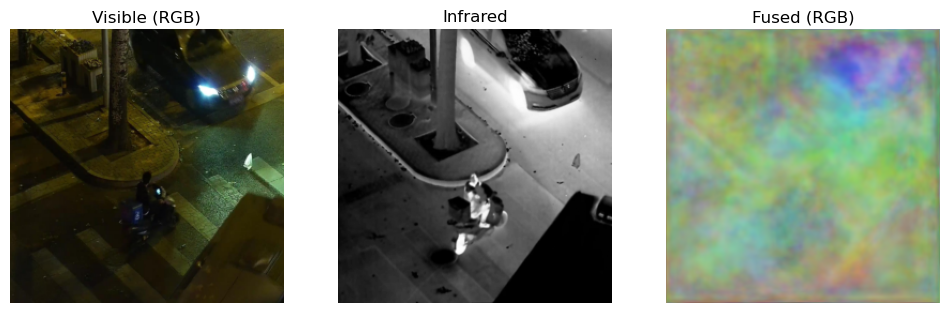

In [ ]:
infer_model()